In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy.spatial.distance import jensenshannon
from adjustText import adjust_text

In [ ]:
# Importing the tables of monthly features.
m1 = pd.read_excel("mth_rolling_features.xlsx")
m2 = pd.read_excel("mth_day_counts.xlsx")
m3 = pd.read_excel("days_since_last_txn.xlsx")

In [3]:
# Importing the response table.
resp = pd.read_csv("Retail_Data_Response.csv")

In [4]:
# Merging the monthly features.
monthly_feat = pd.merge(pd.merge(m1, m2, on=["CLNT_NO", "ME_DT"]), m3, on=["CLNT_NO", "ME_DT"])
# Renaming the 'customer_id' column in the response table to 'CLNT_NO' for joining.
resp.rename(columns={"customer_id": "CLNT_NO"}, inplace=True)
# Joining the monthly features with the response.
monthly_data = pd.merge(monthly_feat, resp, on="CLNT_NO")

monthly_data

,Unnamed: 0_x,CLNT_NO,ME_DT,mth_txn_amt_sum,mth_txn_cnt,amt_sum_3M,amt_mean_3M,amt_max_3M,txn_cnt_sum_3M,txn_cnt_mean_3M,...,cnt_Friday,cnt_Monday,cnt_Saturday,cnt_Sunday,cnt_Thursday,cnt_Tuesday,cnt_Wednesday,Unnamed: 0,days_since_last_txn,response
0,157064,CS1112,2011-05-31,0,0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,157064,-100,0
1,157058,CS1112,2011-06-30,56,1,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,157058,15,0
2,157044,CS1112,2011-07-31,0,0,56.0,18.666667,56.0,1.0,0.333333,...,0,0,0,0,0,0,0,157044,46,0
3,157069,CS1112,2011-08-31,96,1,152.0,50.666667,96.0,2.0,0.666667,...,1,0,0,0,0,0,0,157069,12,0
4,157060,CS1112,2011-09-30,0,0,96.0,32.000000,96.0,1.0,0.333333,...,0,0,0,0,0,0,0,157060,42,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323543,295140,CS9000,2014-11-30,0,0,0.0,0.000000,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,295140,98,0
323544,295126,CS9000,2014-12-31,0,0,0.0,0.000000,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,295126,129,0
323545,295119,CS9000,2015-01-31,0,0,0.0,0.000000,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,295119,160,0
323546,295136,CS9000,2015-02-28,34,1,34.0,11.333333,34.0,1.0,0.333333,...,0,0,1,0,0,0,0,295136,0,0


In [5]:
# Searching for redundant index columns.
monthly_data.columns

Index(['Unnamed: 0_x', 'CLNT_NO', 'ME_DT', 'mth_txn_amt_sum', 'mth_txn_cnt',
       'amt_sum_3M', 'amt_mean_3M', 'amt_max_3M', 'txn_cnt_sum_3M',
       'txn_cnt_mean_3M', 'txn_cnt_max_3M', 'amt_sum_6M', 'amt_mean_6M',
       'amt_max_6M', 'txn_cnt_sum_6M', 'txn_cnt_mean_6M', 'txn_cnt_max_6M',
       'amt_sum_12M', 'amt_mean_12M', 'amt_max_12M', 'txn_cnt_sum_12M',
       'txn_cnt_mean_12M', 'txn_cnt_max_12M', 'Unnamed: 0_y', 'cnt_Friday',
       'cnt_Monday', 'cnt_Saturday', 'cnt_Sunday', 'cnt_Thursday',
       'cnt_Tuesday', 'cnt_Wednesday', 'Unnamed: 0', 'days_since_last_txn',
       'response'],
      dtype='object')

In [6]:
# Dropping the unnecessary NaN rows from window size and the "Unnamed" index columns.
monthly_data.dropna(inplace=True)
monthly_data.drop(columns=["Unnamed: 0", "Unnamed: 0_x", "Unnamed: 0_y"], inplace=True)
monthly_data

,CLNT_NO,ME_DT,mth_txn_amt_sum,mth_txn_cnt,amt_sum_3M,amt_mean_3M,amt_max_3M,txn_cnt_sum_3M,txn_cnt_mean_3M,txn_cnt_max_3M,...,txn_cnt_max_12M,cnt_Friday,cnt_Monday,cnt_Saturday,cnt_Sunday,cnt_Thursday,cnt_Tuesday,cnt_Wednesday,days_since_last_txn,response
11,CS1112,2012-04-30,56,1,56.0,18.666667,56.0,1.0,0.333333,1.0,...,1.0,0,0,0,1,0,0,0,22,0
12,CS1112,2012-05-31,0,0,56.0,18.666667,56.0,1.0,0.333333,1.0,...,1.0,0,0,0,0,0,0,0,53,0
13,CS1112,2012-06-30,52,1,108.0,36.000000,56.0,2.0,0.666667,1.0,...,1.0,0,0,0,1,0,0,0,6,0
14,CS1112,2012-07-31,81,1,133.0,44.333333,81.0,2.0,0.666667,1.0,...,1.0,0,0,0,0,0,1,0,28,0
15,CS1112,2012-08-31,0,0,133.0,44.333333,81.0,2.0,0.666667,1.0,...,1.0,0,0,0,0,0,0,0,59,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323543,CS9000,2014-11-30,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,1.0,0,0,0,0,0,0,0,98,0
323544,CS9000,2014-12-31,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,1.0,0,0,0,0,0,0,0,129,0
323545,CS9000,2015-01-31,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,1.0,0,0,0,0,0,0,0,160,0
323546,CS9000,2015-02-28,34,1,34.0,11.333333,34.0,1.0,0.333333,1.0,...,1.0,0,0,1,0,0,0,0,0,0


In [7]:
# Ensuring the data format of the "ME_DT" column is pd.datetime64.
monthly_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 247824 entries, 11 to 323547
Data columns (total 31 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   CLNT_NO              247824 non-null  object        
 1   ME_DT                247824 non-null  datetime64[ns]
 2   mth_txn_amt_sum      247824 non-null  int64         
 3   mth_txn_cnt          247824 non-null  int64         
 4   amt_sum_3M           247824 non-null  float64       
 5   amt_mean_3M          247824 non-null  float64       
 6   amt_max_3M           247824 non-null  float64       
 7   txn_cnt_sum_3M       247824 non-null  float64       
 8   txn_cnt_mean_3M      247824 non-null  float64       
 9   txn_cnt_max_3M       247824 non-null  float64       
 10  amt_sum_6M           247824 non-null  float64       
 11  amt_mean_6M          247824 non-null  float64       
 12  amt_max_6M           247824 non-null  float64       
 13  txn_cnt_sum_6M    

In [8]:
# Obtaining the client IDs.
clients = monthly_data['CLNT_NO'].unique()
# Shuffling unique client IDs
np.random.seed(15)
np.random.shuffle(clients)
# Splitting the data into two halves based on Client IDs 
train_clients, holdout_clients = np.array_split(clients, 2)
sample_data, holdout_data = monthly_data[monthly_data['CLNT_NO'].isin(train_clients)], monthly_data[monthly_data['CLNT_NO'].isin(holdout_clients)]

print(f"Sample data: {sample_data.shape}, Holdout data: {holdout_data.shape}")

Sample data: (123912, 31), Holdout data: (123912, 31)


In [9]:
# Splitting the sample data into training (up to Dec-2013) and production (test) (Jan-2014 and beyond).
train, test = sample_data[sample_data["ME_DT"] <= "2013-12-31"], sample_data[sample_data["ME_DT"] >= "2014-01-01"]
X_train, y_train = train.drop(columns=["CLNT_NO", "ME_DT", "response"]), train["response"]

print(f"Train data: {train.shape}, Test data: {test.shape}")

Train data: (72282, 31), Test data: (51630, 31)


In [10]:
# Confirming the date-based data split.
train["ME_DT"].describe()

count                            72282
mean     2013-03-01 01:08:34.285714176
min                2012-04-30 00:00:00
25%                2012-09-30 00:00:00
50%                2013-02-28 00:00:00
75%                2013-07-31 00:00:00
max                2013-12-31 00:00:00
Name: ME_DT, dtype: object

In [11]:
# Best Random_forest
model = RandomForestClassifier(max_depth=5, class_weight="balanced", random_state=1147)
# Fitting the model.
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=1147)

[Text(0.5, 0, 'Baseline Score'), Text(0, 0.5, 'Frequency')]

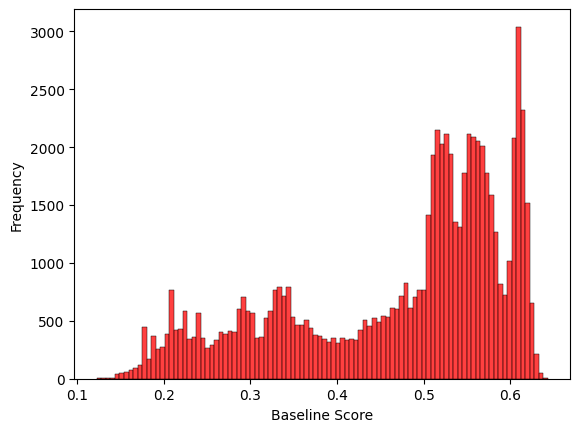

In [12]:
# Calculating the baseline distributions using the train scores.
baseline_scores = model.predict_proba(X_train)[:, 1]
# Visualizing the histplot of the baseline scores distribution.
ax = sns.histplot(baseline_scores,                
                  color='red',
                  bins=100)
ax.set(xlabel='Baseline Score', ylabel='Frequency')

In [13]:
# Veiwing the distribution baseline distribution.
np.histogram(baseline_scores)

(array([  455,  4104,  3709,  5463,  5448,  3614,  5900, 15157, 16814,
        11618], dtype=int64),
 array([0.12283961, 0.17487939, 0.22691916, 0.27895893, 0.33099871,
        0.38303848, 0.43507825, 0.48711803, 0.5391578 , 0.59119757,
        0.64323735]))

#### Answer (Bin edge decision):
- The last 4 bins include 64% of the samples. It would be better to use the quantile bins, this way, every bin has approximately 10% of the 72,282 population.

In [14]:
# Setting the bin edges based on each having 10% of the population.
bin_edges = np.quantile(baseline_scores, np.arange(0, 1.1, 0.1))
bin_edges[0]=0 # We replace the first element with zero since it's the lower cap
bin_edges

array([0.        , 0.26540613, 0.33574646, 0.42183564, 0.4890978 ,
       0.51753651, 0.53720134, 0.55854533, 0.5783518 , 0.60776174,
       0.64323735])

In [15]:
# Calculating the left vector p.
p = np.histogram(baseline_scores, bin_edges)
p

(array([7229, 7228, 7228, 7227, 7229, 7228, 7228, 7228, 7228, 7229],
       dtype=int64),
 array([0.        , 0.26540613, 0.33574646, 0.42183564, 0.4890978 ,
        0.51753651, 0.53720134, 0.55854533, 0.5783518 , 0.60776174,
        0.64323735]))

In [16]:
# Obtaining the baseline feature importances.
base_importance = model.feature_importances_

# Selecting the indexes of the top 5 features based on baseline importance.
sort_idx = np.argsort(base_importance)[-5:][::-1]
base_feat_top5 = [X_train.columns[i] for i in sort_idx]
base_feat_top5

['amt_max_12M', 'amt_sum_12M', 'amt_mean_12M', 'amt_max_6M', 'amt_mean_6M']

In [17]:
# Computing the histograms for the top 5 important features for feature distributions and storing as a dictionary
baseline_feature_distributions = {}
feature_bin_edges = {}

for feature in base_feat_top5:
    # Normalizing by the max to ensure the values are within [0,1] like a probabilty score.
    feature_data = X_train[feature] / X_train[feature].max()  
    # Setting the bin edges based on each having 10% of the feature population.
    f_bin_edges = np.quantile(feature_data, np.arange(0, 1.1, 0.1))
    f_bin_edges[0] = 0 
    feature_bin_edges[feature] = f_bin_edges
    # Compiling the baseline feature histogram and bin edges
    feature_hist = np.histogram(feature_data, bins=f_bin_edges)[0]
    baseline_feature_distributions[feature] = feature_hist

baseline_feature_distributions, feature_bin_edges

({'amt_max_12M': array([6999, 7238, 7081, 7571, 6596, 7794, 7238, 7183, 7171, 7411],
        dtype=int64),
  'amt_sum_12M': array([7146, 7203, 7304, 7193, 7254, 7157, 7333, 7181, 7280, 7231],
        dtype=int64),
  'amt_mean_12M': array([7146, 7203, 7304, 7193, 7254, 7157, 7333, 7181, 7280, 7231],
        dtype=int64),
  'amt_max_6M': array([    0, 14286,  7205,  6950,  7233,  7583,  6907,  7484,  7382,
          7252], dtype=int64),
  'amt_mean_6M': array([    0, 14270,  7390,  7148,  7206,  7210,  7194,  7309,  7311,
          7244], dtype=int64)},
 {'amt_max_12M': array([0.        , 0.13768116, 0.17391304, 0.19565217, 0.22705314,
         0.24396135, 0.27777778, 0.33333333, 0.38164251, 0.44444444,
         1.        ]),
  'amt_sum_12M': array([0.        , 0.06909643, 0.11085801, 0.14730448, 0.18299165,
         0.21943812, 0.25664389, 0.29916477, 0.34776006, 0.4198937 ,
         1.        ]),
  'amt_mean_12M': array([0.        , 0.06909643, 0.11085801, 0.14730448, 0.18299165,
     

C:\Users\Adaora Uzokwe\AppData\Local\Temp\ipykernel_26228\3755831707.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for i, (month, group) in enumerate(test.groupby(pd.Grouper(key="ME_DT", freq="M"))):


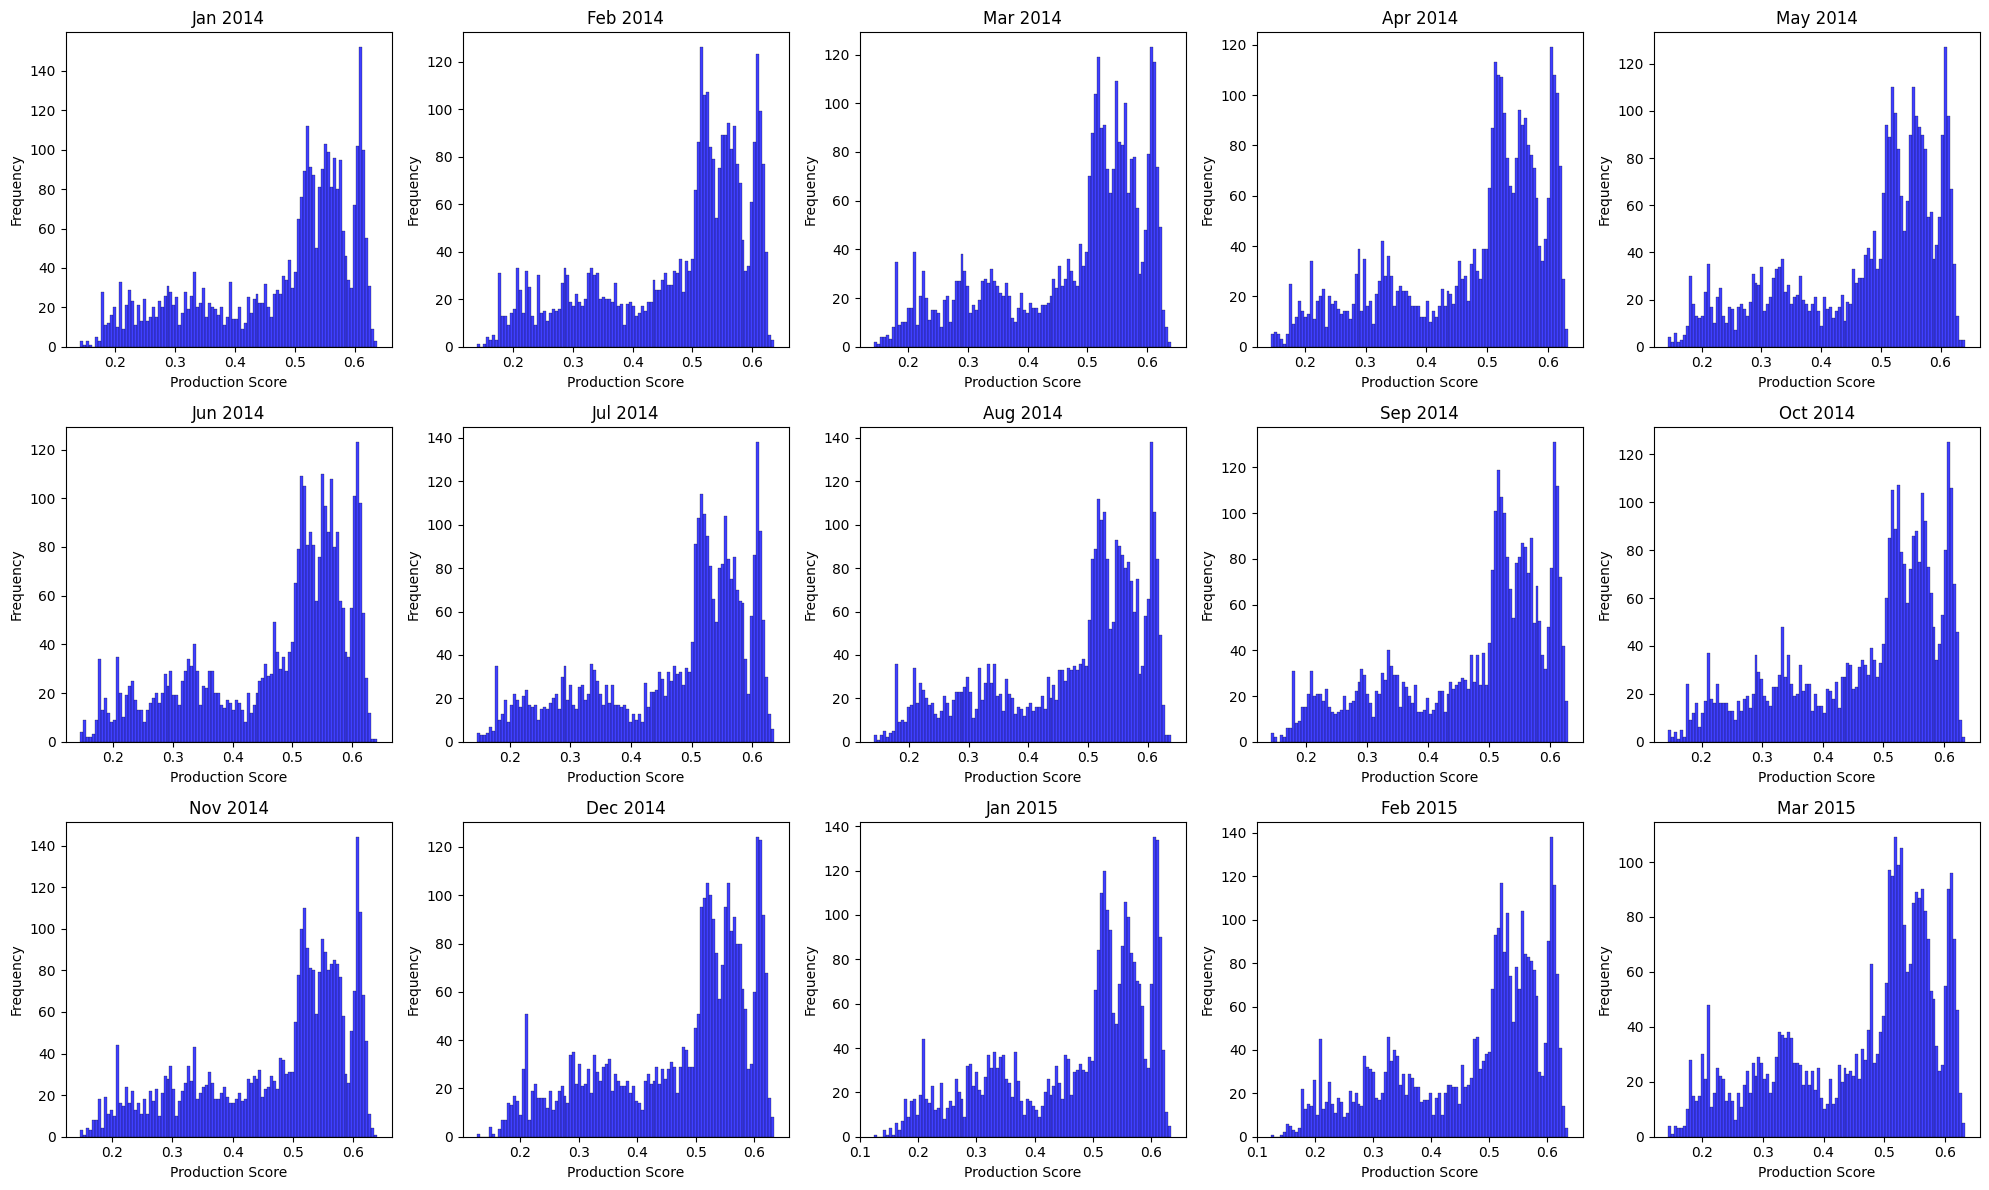

,Score,amt_max_12M,amt_sum_12M,amt_mean_12M,amt_max_6M,amt_mean_6M
Month,,,,,,
2014-01-31,0.021358,0.025152,0.031186,0.031186,0.021930,0.091609
2014-02-28,0.021471,0.027566,0.063710,0.063710,0.023646,0.091661
2014-03-31,0.023666,0.026293,0.034756,0.034756,0.023409,0.026096
2014-04-30,0.026274,0.023436,0.077612,0.077612,0.206379,0.031853
2014-05-31,0.018539,0.025515,0.031658,0.031658,0.204303,0.133816
2014-06-30,0.020973,0.025894,0.064631,0.064631,0.209359,0.085344
2014-07-31,0.029014,0.032179,0.106679,0.106679,0.201929,0.098829
2014-08-31,0.031502,0.031911,0.125947,0.125947,0.201107,0.102443
2014-09-30,0.026679,0.028178,0.092748,0.092748,0.192593,0.066771


In [ ]:
# Monitoring the monthly drift for Jan-2014 and beyond.
# Creating lists to store the data for each month.
jsd_scores = []
jsd_features = []
# Creating a figure for subplots for production score distribution.
fig, axes = plt.subplots(3, 5, figsize=(20, 12)) 
axes = axes.flatten() 

# Using grouper to specify the frequency of the groupby as Monthly in "ME_DT" for production (test) data.
for i, (month, group) in enumerate(test.groupby(pd.Grouper(key="ME_DT", freq="M"))):
    # Calculating the distribution for each month using the test scores for the month.
    X_test = group.drop(columns=["CLNT_NO", "ME_DT", "response"])
    scores_test = model.predict_proba(X_test)[:, 1]
    
    # Visualizing the histplot of the production scores distribution.
    ax = axes[i]
    sns.histplot(scores_test, color='blue', bins=100, ax=ax)
    ax.set(xlabel='Production Score', ylabel='Frequency', title=month.strftime("%b %Y"))

    # Calculating the right probabilty vector q.
    q = np.histogram(scores_test, bins=bin_edges)
    # Computing the Jensen-Shannon divergence metric with the training data as the baseline distributions.
    jsd_score = jensenshannon(p[0], q[0], 2.0)
    # Computing the Jensen-Shannon divergence metric for drift in feature distributions for the top 5 baseline features
    jsd_feat = []
    for feature in base_feat_top5:
        # Normalizing the feature data in the test set
        feature_data_test = X_test[feature] / X_test[feature].max()
        # Using the precomputed feature bin edges from the training data
        feature_hist_test = np.histogram(feature_data_test, bins=feature_bin_edges[feature])
        # Computing the Jensen-Shannon divergence for the feature distribution
        jsd_feat.append(jensenshannon(baseline_feature_distributions[feature], feature_hist_test[0], 2.0))
    jsd_scores.append((month, jsd_score))
    jsd_features.append(jsd_feat)
plt.tight_layout()
plt.show()

# Converting to DataFrame
jsd_scores_df = pd.DataFrame(jsd_scores, columns=["Month", "Score"])
jsd_features_df = pd.DataFrame(jsd_features, columns=[f'{col}' for col in base_feat_top5])
drift_df = pd.concat([jsd_scores_df, jsd_features_df], axis=1).reset_index(drop=True)
drift_df = drift_df.set_index('Month')
drift_df


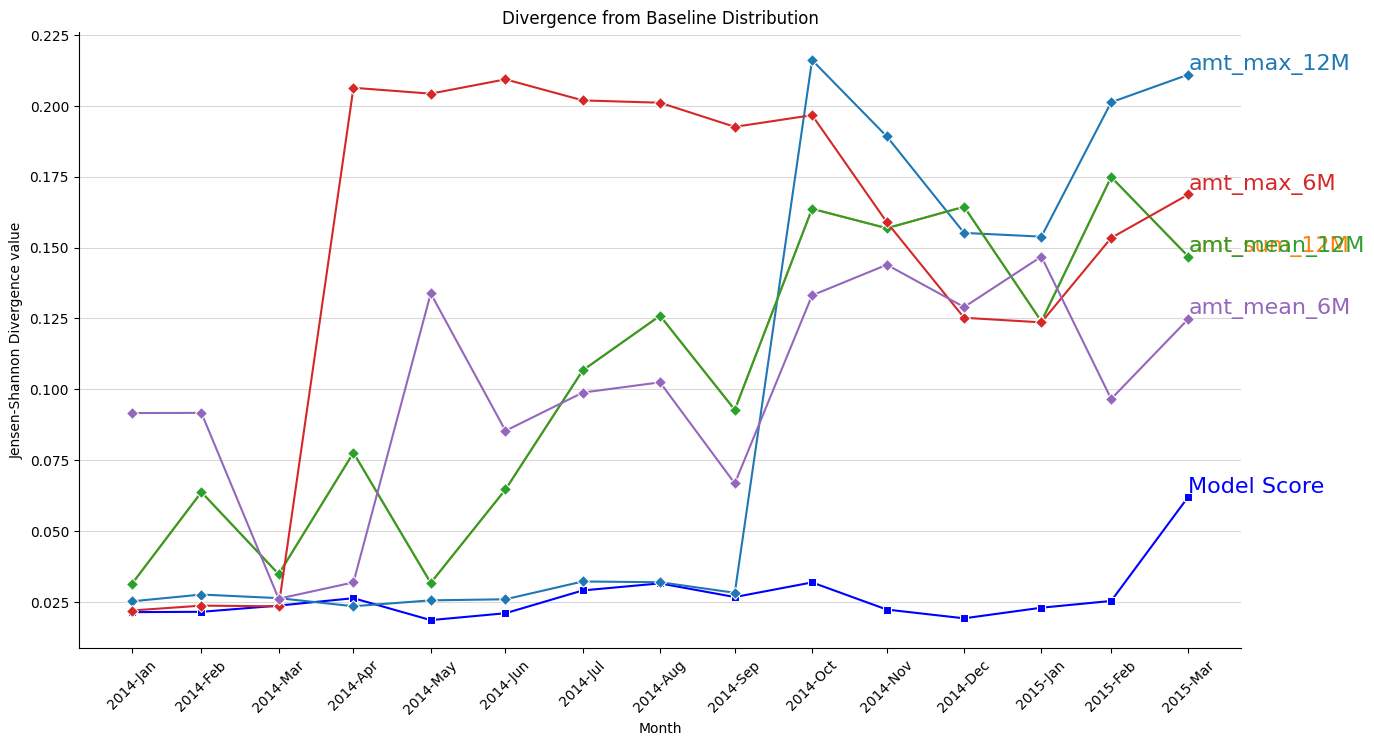

In [21]:
# Visualizing the Jensen-Shannon divergence values for the monthly model score drift and top 5 feature drift.
plt.figure(figsize=(15, 8))
# Plotting the monthly scores.
sns.lineplot(data=drift_df, x=drift_df.index, y='Score', marker='s', color='b')
# Adding text at the end of the Score line.
score_line_color = 'b' 
plt.text(drift_df.index[-1], drift_df['Score'].iloc[-1], 'Model Score', color=score_line_color, ha='left', va='bottom', fontsize=16)

texts = []
# Plotting the monthly top 5 features.
for idx, col in enumerate(base_feat_top5):
    line_color = sns.color_palette("tab10")[idx % 10]
    sns.lineplot(data=drift_df, x=drift_df.index, y=col, marker='D', color=line_color)
    # Adding in text at the end of each feature line.
    last_jsd_value = drift_df[col].iloc[-1]
    text = plt.text(drift_df.index[-1], last_jsd_value, col, color=line_color, ha='left', va='bottom', fontsize=16)
    texts.append(text)
#adjust_text(texts)

# Removing the top and right spines for better visibility.
plt.gca().spines[['top', 'right']].set_visible(False)
# Ensuring labels match the months.
plt.xticks(drift_df.index, drift_df.index.strftime('%Y-%b'), rotation=45)
plt.grid(True, axis='y', linestyle='-', color='gray', alpha=0.3) 
plt.xlabel('Month')
plt.ylabel('Jensen-Shannon Divergence value')
plt.title('Divergence from Baseline Distribution')
plt.legend('',frameon=False)

plt.show()


#### Answer (Interpretation of Results):
- Model Score Drift (JSD of model scores):

From observation, the Jensen-Shannon Divergence values for the model scores show no significant drift from the baseline distribution and the scores exhibit stability until the final month in production (2015-March) where the scores' distribution experiences a higher drift than previously observed. This sudden spike at the end may be indication of an external factor affecting the model's predictions such as a data pipeline issue. The overall nature of the low JSD values for the drift of the score predictions' distribution from the baseline distribution suggests that the model is stable and may be reliable. This behaviour can be justified from the fact that the prediction scores histoplots for each of the 15 months all have the same general type of left-skewed poisson distribution that is also present in the histoplot of the baseline scores.

- Feature Drift (Top 5 Features):

It can be observed that the JSD values for drift of all five features' distribution from their baseline distribution at the start of production are much smaller (and sometimes the lowest) than the JSD values for drift at the end likely as a result of a change in ground truth such as shifting customer preference.
1. amt_max_12M: The JSD values remains low from the start of production indicating more consistent distributions at those months until a very significant drift is obsvered at 2014-February with a JSD value greater than 0.2 then the drift falls a bit before evntually going above 0.2 again towards the end.
2. amt_mean_12M: The drift fluctuates between relatively small values then gradually increases but never goes beyond a JSD value of 0.2.
3. amt_sum_12M: After the normalization, it can be obsereved in the bins that this feature has the exact same distribution of values in bins as 'amt_mean_12M' (they are highly correlated) and therefore exhibits the same drift characteristics as that feature.
4. amt_max_6M: The JSD value remains low then a very signifcant drift (>0.2) is recorded at 2014-April till 2014-August where the drift decreases then subsequently increases slightly towards the end.
5. amt_mean_6M: This feature, being the least important of the top 5 features, exhibits the most drift of any other feature at the start of production, then it displays short large flunctuations but increases overall.

High JSD experienced by features is as a result of external factors. The drift values greater than 0.2 signify a difference in distribution while values close to 0 indicate not so much of a difference in the distributions. The features 'amt_max_12M' and 'amt_max_6M' are the only ones that actually experience more extreme distribution differences ('amt_max_12M' drift occuring 6 months after 'amt_max_6M' displaying the correlation between the two features) as they are the only features that have months where the drift values went beyond 0.2. Multiple features have relatively larger drifts at 2014-October which is a sign of a data drift; an indication of overall distribution change in the model, though not so signficant for this case.

- Score and feature drift relationship:

The model score drift and feature drift do not increase together, based on the theory of Concept drift, this means that the target has not changed and the model is considered to still be reliable. Furthermore, it can be concluded that the model still performs regardless of the changes in the data. 
